# Task 1. Time series analysis.
## Step 1. Find one real-world time-series from any open-source (not less than 150 time steps).
To accomplish this task I obtained 2 m air temperature (t2m) time series from climate reanalysis *ERA5 on single levels*, distributed in the form of netCDF4 files (*.nc*). This dataset has 0.25 degrees spatial and daily temporal resolution, so I decided to analyze monthly values of t2m for Saint-Petersburg over the period of 2000-2020.

P.s. as the raw data are extremely heavy I'm attaching only the final time series.

In [36]:
"""Run the cell if you want to process raw data"""
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
path = '/run/media/alex/One Touch/ERA5/'
years = [year for year in range(2000, 2023,1)]
d = {}
for year in years:
    files = os.listdir(path+str(year))
    for f in files:
        if f.split('.')[2]=='surface_net_solar_radiation':
            name = f
    data=xr.open_dataset(os.path.join(path,str(year),name), engine='netcdf4').resample(time='M').mean('time')
    var=[i for i in data.data_vars]
    if 'nssr' not in globals():
        nssr=data[var[0]].sel(latitude=59.93, longitude=30.36, method = 'pad').to_numpy()
    else:
        nssr=np.concatenate((nssr, data[var[0]].sel(latitude=59.93, longitude=30.36, method = 'pad').to_numpy()))
    data.close()
np.savetxt('nssr.dat', nssr)

<AxesSubplot: xlabel='dates', ylabel='t2m'>

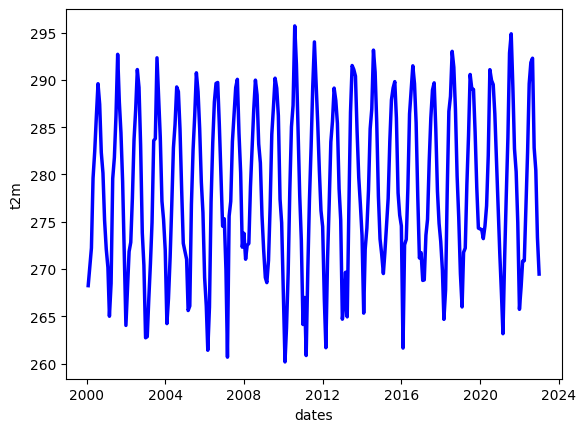

In [1]:
"""Run the cell if you want to upload the pre-processed dataset"""
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from itertools import product
import os
import warnings

%matplotlib inline

warnings.filterwarnings('ignore')

t2m = np.loadtxt('t2m.dat')
dates = pd.date_range(start='2000-01-01', end='2023-01-01', freq='M')
t2m = pd.DataFrame({'dates':dates,'t2m': t2m})
sns.lineplot(data=t2m, x='dates', y='t2m', color='blue',  linewidth=2.5)
#sns.lineplot(data=t2m.loc[:200,:], x='dates', y='t2m', color='blue', label='t2m_train', linewidth=2.5)
#sns.lineplot(data=t2m.loc[200:,:], x='dates', y='t2m', color='red', label='t2m_test',linewidth=2.5)
#plt.legend()

Dickey-Fuller test: p=0.055759


<Figure size 1500x1000 with 0 Axes>

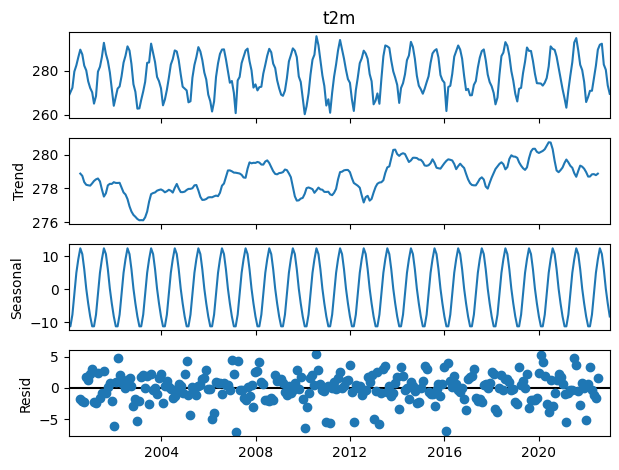

In [2]:
#stationarity test + seasonal decomposition (as p-value is higher than 0.05 we assume that the time series 
#is stationary
t2m = t2m.set_index('dates')

plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(t2m.t2m).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(t2m.t2m)[1])

## Step 2. Implement Multi-step LSTM and ARIMA.
## ARIMA

Best Box-Cox parameter: 2.520327
Dickey-Fuller test: p=0.058864


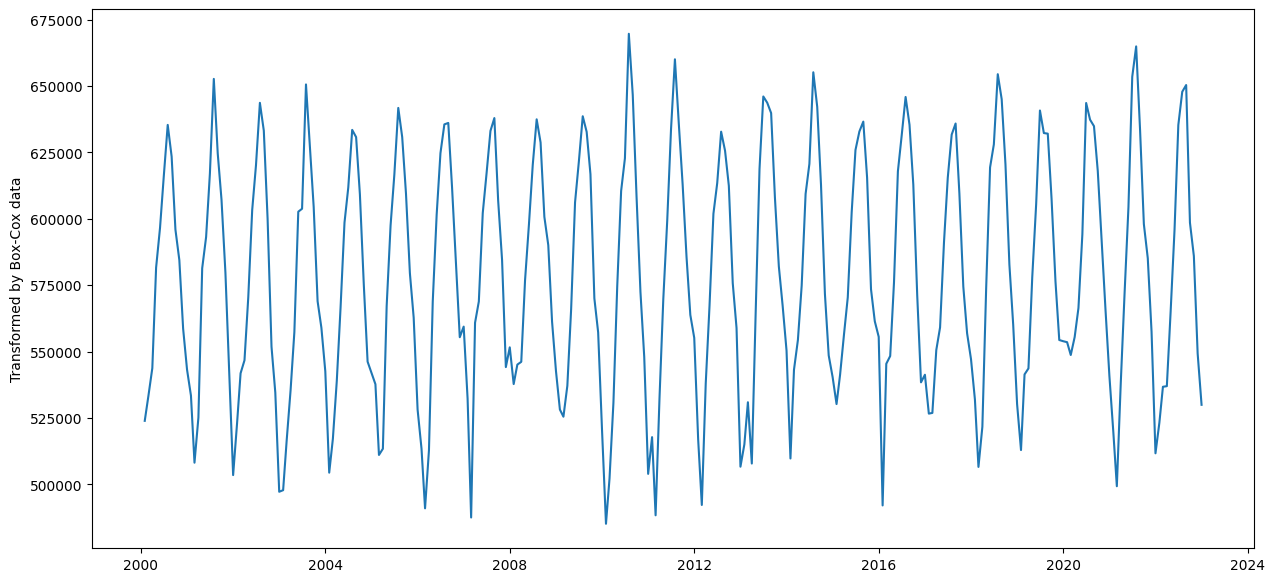

In [3]:
# Box-Cox transformation for dispersion stationarity

t2m['t2m_box'], lmbda = stats.boxcox(t2m['t2m'])
plt.figure(figsize=(15,7))
plt.plot(t2m['t2m_box'])
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(t2m['t2m_box'])[1])

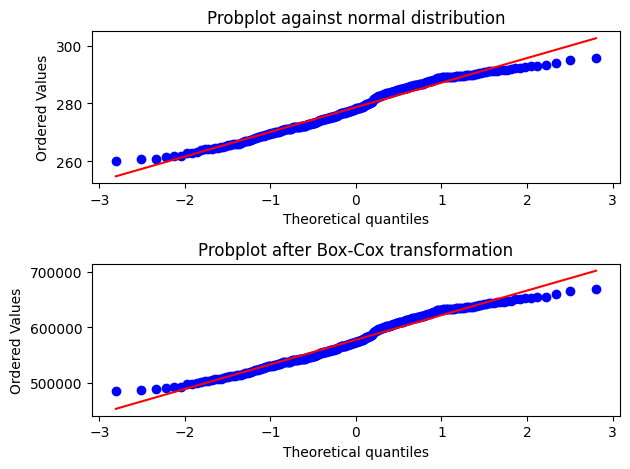

In [4]:
#Checking if Box-Cox transformation altered the time series to resemble normal dist
fig = plt.figure()

ax1 = fig.add_subplot(211)
prob = stats.probplot(t2m.t2m, dist=stats.norm, plot=ax1)
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
prob = stats.probplot(t2m.t2m_box, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.tight_layout()

In [5]:
#choosing parameters combinations for ARIMA
ps = range(0, 6)   # 5
d = 1
qs = range(0, 6)  # 5
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [6]:
results = []
best_aic = float("inf")

for param in parameters_list:

    try:
        model=sm.tsa.statespace.SARIMAX(t2m['t2m_box'].iloc[:228], order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)

    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
3  (1, 0, 1, 0)  4875.457736
2  (0, 1, 1, 0)  4878.201317
1  (0, 0, 1, 0)  4879.114417
0  (0, 0, 0, 0)  4896.746821


In [7]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            t2m_box   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -2434.729
Date:                            Tue, 26 Sep 2023   AIC                           4875.458
Time:                                    09:26:16   BIC                           4885.570
Sample:                                01-31-2000   HQIC                          4879.543
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0631      0.013     -4.780      0.000      -0.089      -0.037
ar.S.L12      -0.1603      0.012   

Student test: p=0.627650
Dickey-Fuller test: p=0.0000098691953436017712076


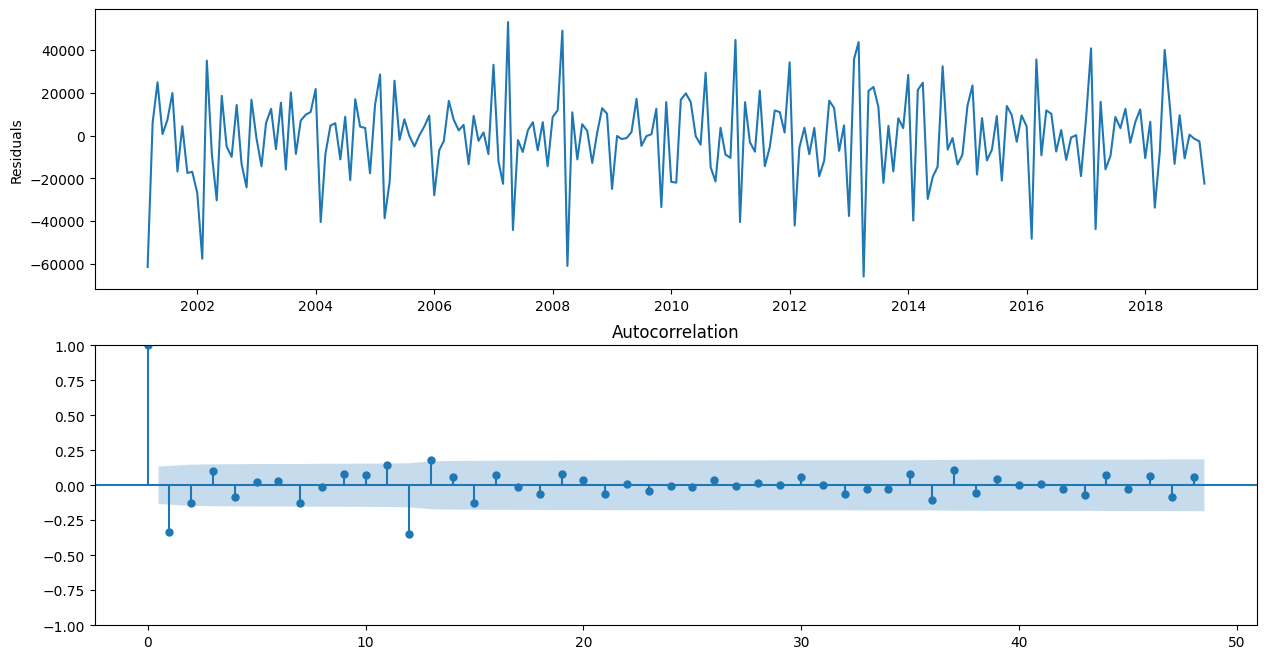

In [8]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(best_model.resid[13:])
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

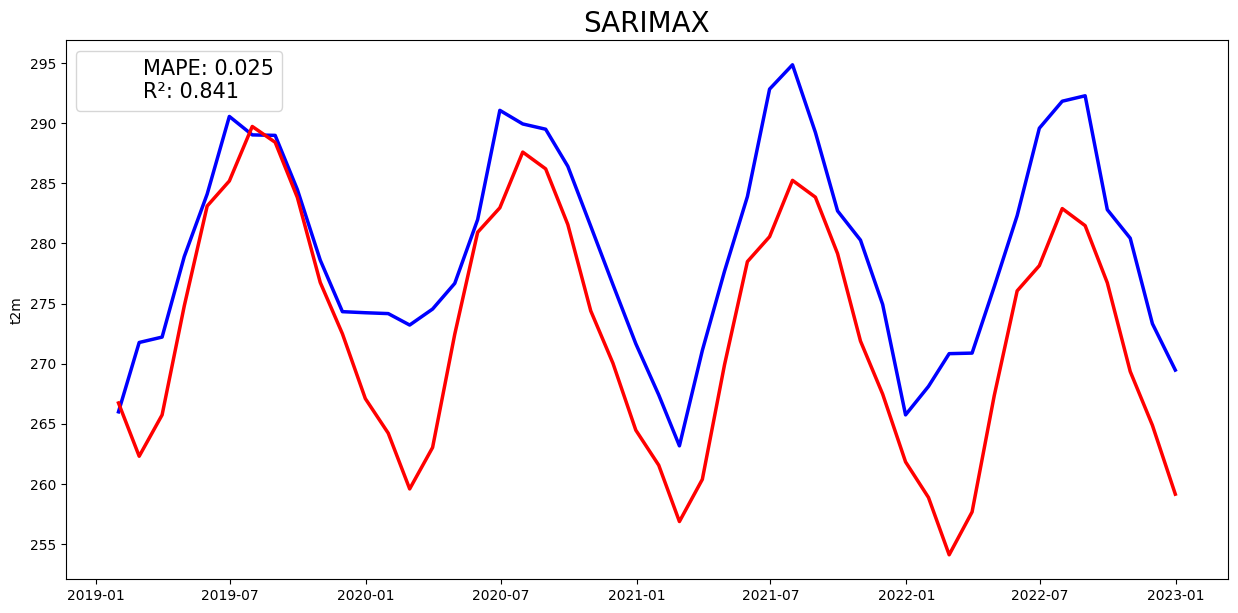

In [22]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score as R2

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
# sklearn function gave me negative R^2, so I squared Pearson's coeffcient manually
def r2(true, pred):
    r = sum((true-true.mean())*(pred-pred.mean()))/(sum((true-true.mean())**2)*sum((pred-pred.mean())**2))**0.5
    return round(r**2,3)

model = invboxcox(best_model.forecast(48), lmbda)

SARIMAX_r2 = r2(t2m['t2m'].iloc[228:], model)
SARIMAX_MAPE = round(MAPE(t2m['t2m'].iloc[228:], model),3)

plt.figure(figsize=(15,7))
plt.plot([], label=f'MAPE: {SARIMAX_MAPE}\nR\u00b2: {SARIMAX_r2}', color='w')
plt.plot(t2m['t2m'].iloc[228:], color='blue', lw=2.5)
plt.plot(model,color='r',lw=2.5)
plt.ylabel('t2m')
plt.legend(loc='upper left',frameon=True, prop={'size':15})
plt.title('SARIMAX', fontsize=20)
plt.show()


## Multi-step LSTM

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()

    # stateful = True - keep state in memory;

    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss

# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

#  inverse_difference
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

2023-09-26 10:37:57.733865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 10:38:00.674648: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 10:38:00.677337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 10:38:09.679709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [28]:
# historical lag - multiple of 12 - length of the input vector
n_lag = 82
# forecasting period
n_seq = 48
# number of test samples
n_test = 20
# number of epochs for training
n_epochs = 10
# batch size
n_batch = 1
# number of LSTM cells
n_neurons = 15

# dataset preparation
scaler, train, test = prepare_data(t2m.t2m.iloc[:228], n_test, n_lag, n_seq)
# train the model
model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts for n_seq steps
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse scaling
forecasts = inverse_transform(t2m.t2m.iloc[:228], forecasts, scaler, n_test+2)

2023-09-26 10:38:26.124278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-26 10:38:26.126558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-26 10:38:26.128351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

0


2023-09-26 10:38:26.949188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-26 10:38:26.950666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-26 10:38:26.951832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

70/70 [==============================] - 3s 8ms/step - loss: 0.1568 - val_loss: 0.1279
1
 1/70 [..............................] - ETA: 0s - loss: 0.1524

2023-09-26 10:38:29.368776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-26 10:38:29.370373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-26 10:38:29.371781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

70/70 [==============================] - 0s 2ms/step - loss: 0.1142 - val_loss: 0.0960
2
70/70 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0762
3
70/70 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0686
4
70/70 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0664
5
70/70 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0659
6
70/70 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0658
7
70/70 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0660
8
70/70 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0662
9
70/70 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0664
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 15)             

2023-09-26 10:38:31.179752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-26 10:38:31.181173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-26 10:38:31.182319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 12ms/step


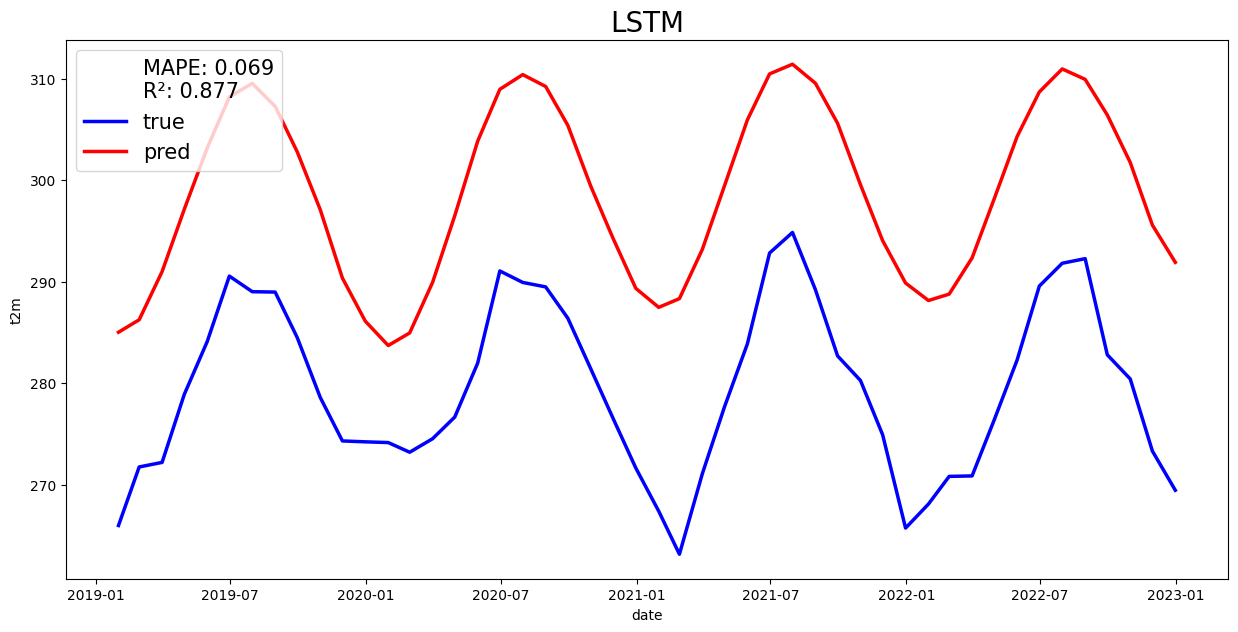

In [32]:
LSTM_r2 = r2(t2m['t2m'].iloc[228:], np.array(forecasts[-1]))
LSTM_MAPE = round(MAPE(t2m['t2m'].iloc[228:], np.array(forecasts[-1]).reshape(-1,1)),3)

plt.figure(figsize=(15,7))
plt.plot([], label=f'MAPE: {LSTM_MAPE}\nR\u00b2: {LSTM_r2}', color='w')
#plt.text(x=1, y=1,s=f'MAPE: {LSTM_MAPE}\nR\u00b2: {LSTM_r2}')
plt.plot(t2m['t2m'].iloc[228:], color='blue', lw=2.5, label='true')
plt.plot(t2m.index[228:],forecasts[-1],color='r', lw=2.5, label='pred')
plt.ylabel('t2m')
plt.xlabel('date')
plt.legend(loc='upper left',frameon=True, prop={'size':15})
plt.title('LSTM', fontsize=20)
plt.show()


# Conclusion.

The models were built to forecast 2 m air temperature for the nex 48 month (4 years). According to the modeling results LSTM a little bit better describes variance in t2m, however its MAPE almost 3 times bigger than SARIMAX's, which means that the first model has a higher bias. So in this case SARIMAX is a superior.
It also can be seen from the plots of the SARIMAX forecast, that we could rely on it predictions for the first year and half, but after 18 month its prediction gets much worse. It absolute error is up to 10 degrees, wich is too rough for the forecast of monthly temperature. 